In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import os

In [6]:
# Generamos datos aleatorios para las matrices Householder
v = np.zeros((20, 5))
for i in range(0, 20):
    v[i] = np.random.randint(1, 20, size=5)

if os.path.exists('../potencia-deflacion/experimento/entrada/vectores.txt'):
    os.remove('../potencia-deflacion/experimento/entrada/vectores.txt')

with open('../potencia-deflacion/experimento/entrada/vectores.txt', 'a') as vectores:
    np.savetxt(vectores, v, newline="\n")

res = np.zeros((20, 5)) # para promedio del error de cada Householder por cada epsilon
stds = np.zeros((20, 5)) # para desviación estándar del error
convergencias_res = np.zeros((20, 5))

eps = np.logspace(-4, 0, 20, dtype=np.float64)

if os.path.exists('../potencia-deflacion/experimento/entrada/eps.txt'):
    os.remove('../potencia-deflacion/experimento/entrada/eps.txt')

with open('../potencia-deflacion/experimento/entrada/eps.txt', 'a') as epsilon:
    np.savetxt(epsilon, eps)


In [7]:
def convergencia():
    subprocess.run([
        'g++', '-o', '../potencia-deflacion/experimento/entrada/met_potencia', 
        '../potencia-deflacion/met_potencia.cpp', '-std=c++11', '-I', 'Eigen', '-O3'
    ])

    v = np.loadtxt('../potencia-deflacion/experimento/entrada/vectores.txt')
    eps = np.loadtxt('../potencia-deflacion/experimento/entrada/eps.txt')

    res = np.zeros((20, 5))
    stds = np.zeros((20, 5))
    convergencias_res = np.zeros((20, 5))

    for i in range(20):
        D = np.diag([10, 10 - eps[i], 5, 2, 1])
        normas = np.zeros((20, 5))
        convergencia = np.zeros((20, 5))

        for j in range(20):
            v_actual = v[j]
            v_actual = v_actual / np.linalg.norm(v_actual)
            v_actual = np.reshape(v_actual, (len(D), 1))

            B = np.eye(D.shape[0]) - 2 * (v_actual @ v_actual.T)
            M = B.T @ D @ B

            # Aplicamos el método de potencia para encontrar el primer autovalor y autovector
            if os.path.exists(f'../potencia-deflacion/experimento/entrada/prueba{i}.txt'):
                os.remove(f'../potencia-deflacion/experimento/entrada/prueba{i}.txt')

            with open(f'../potencia-deflacion/experimento/entrada/prueba{i}.txt', 'a') as f:
                f.write(f"{M.shape[0]} {M.shape[1]}\n")
                np.savetxt(f, M, newline="\n")

            result = subprocess.run([
                "../potencia-deflacion/experimento/entrada/met_potencia",
                f"../potencia-deflacion/experimento/entrada/prueba{i}.txt"
            ], stdout=subprocess.PIPE)

            if os.path.exists(f'../potencia-deflacion/experimento/salida/salida{i}.txt'):
                os.remove(f'../potencia-deflacion/experimento/salida/salida{i}.txt')

            with open(f'../potencia-deflacion/experimento/salida/salida{i}.txt', "a") as output:
                output.write(result.stdout.decode('utf-8'))

            arr = np.loadtxt(f'../potencia-deflacion/experimento/salida/salida{i}.txt')
            w = arr[1]
            c = arr[0]
            V = np.delete(arr, [0, 1], axis=0).reshape((len(D), len(D)))

            for m in range(len(w)):
                error = ((M @ V[:, m]) - (w[m] * V[:, m]))
                normas[j][m] = np.linalg.norm(error, ord=2)
                convergencia[j][m] = c[m]

            # Actualizar matriz M con deflación
            for k in range(len(w)):
                vk = V[:, k].reshape(-1, 1)
                M = M - w[k] * (vk @ vk.T)

        promedio_error = normas.mean(axis=0)
        std_error = normas.std(axis=0)
        promedio_convergencia = convergencia.mean(axis=0)

        res[i] = promedio_error
        stds[i] = std_error
        convergencias_res[i] = promedio_convergencia

    data = {'error1': res[:, 0], 
            'error2': res[:, 1], 
            'error3': res[:, 2], 
            'error4': res[:, 3], 
            'error5': res[:, 4],
            'std1': stds[:, 0], 
            'std2': stds[:, 1], 
            'std3': stds[:, 2], 
            'std4': stds[:, 3], 
            'std5': stds[:, 4],
            'convergencia1': convergencias_res[:, 0], 
            'convergencia2': convergencias_res[:, 1], 
            'convergencia3': convergencias_res[:, 2], 
            'convergencia4': convergencias_res[:, 3], 
            'convergencia5': convergencias_res[:, 4], 
            'eps': eps}
    
    df = pd.DataFrame(data, columns=['error1', 'error2', 'error3', 'error4', 'error5', 'std1', 'std2', 'std3', 'std4', 'std5', 
                                     'convergencia1', 'convergencia2', 'convergencia3', 'convergencia4', 'convergencia5', 'eps'])

    if os.path.exists('../potencia-deflacion/experimento/datosGrafico.csv'):
        os.remove('../potencia-deflacion/experimento/datosGrafico.csv')
    
    df.to_csv('../potencia-deflacion/experimento/datosGrafico.csv')

    return

Para volver a correr el experimento, descomentar:

In [ ]:
# convergencia()

### Gráficos

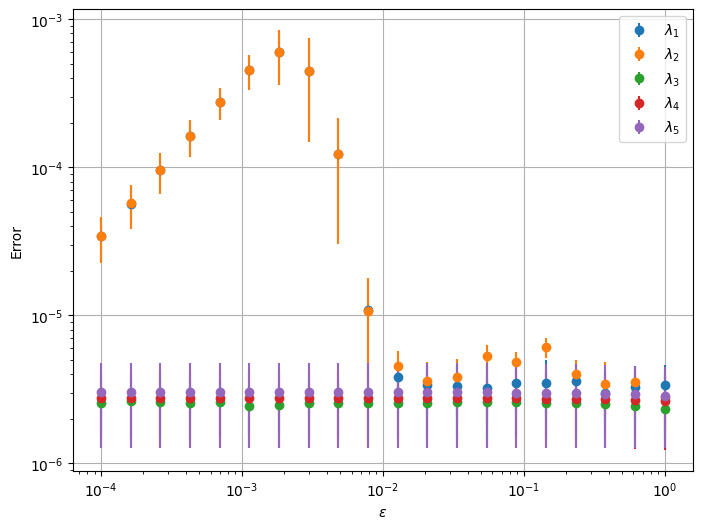

In [8]:
df = pd.read_csv('../potencia-deflacion/experimento/datosGrafico.csv')

# Crear el gráfico
plt.figure(figsize=(8, 6))
for i in [1, 2,3, 4, 5]:
    plt.errorbar(df['eps'], df[f'error{i}'], yerr=df[f'std{i}'], label=f'$\lambda_{i}$', fmt='o')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\epsilon$')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.savefig('../graficos/met-potencia-epsilon.png')
plt.show()

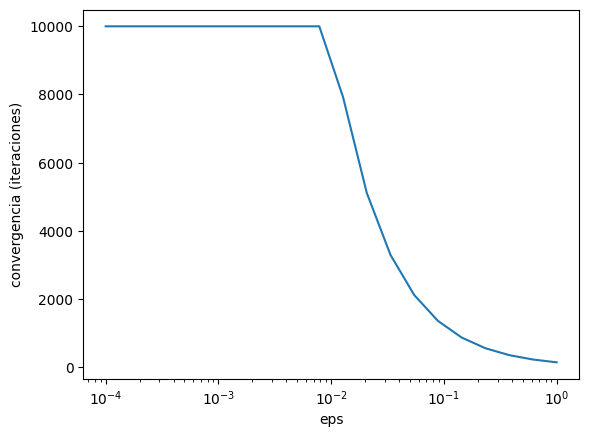

In [9]:
df = pd.read_csv("experimento/datosGrafico.csv")

plt.plot(df["eps"],df["convergencia1"])
plt.xscale('log')

plt.xlabel("eps")
plt.ylabel("convergencia (iteraciones)")
plt.savefig('../graficos/met-potencia-eps.png')

plt.show()


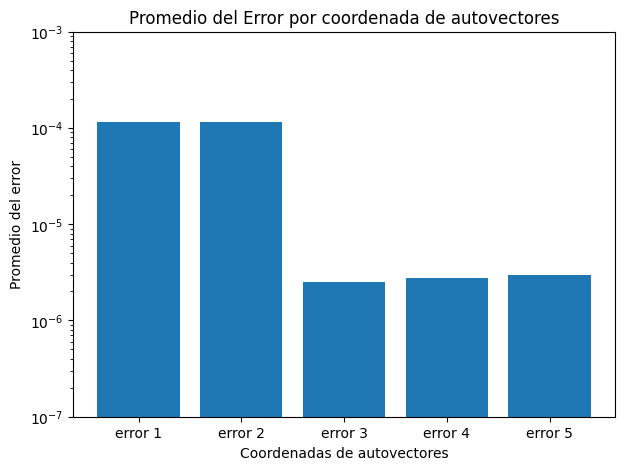

In [12]:
mean_errors = df[['error1', 'error2', 'error3', 'error4', 'error5']].mean()

plt.figure(figsize=(7, 5))
plt.bar([f'error {i+1}' for i in range(5)], mean_errors)
plt.yscale('log')
plt.ylim(1e-7, 1e-3)  # Ajusta estos valores según el rango deseado
plt.ylabel('Promedio del error')

plt.xlabel('Coordenadas de autovectores')
plt.title('Promedio del Error por coordenada de autovectores')
plt.savefig('../graficos/met-potencia-error.png')
plt.show()